In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

In [2]:
from einops import rearrange

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
import sys
sys.path.append("../")
from simulator.lensing import LensingSim

In [5]:
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

download_mnist()
save_mnist()

mnist_sq = rearrange(load()[0], 'b (h w) -> b h w', h=28)

Download complete.
Save complete.


In [6]:
# Don't worry about these
exposure = 1610.0
n_xy = 96
pixel_size = 0.1
mag_zero=25.5
mag_iso=31.5
mag_s = 26.5
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = LensingSim._mag_to_flux(mag_iso, mag_zero)
S_tot = LensingSim._mag_to_flux(mag_s, mag_zero)

observation_dict = {
    "n_x": n_xy,
    "n_y": n_xy,
    "theta_x_lims": (-coordinate_limit, coordinate_limit),
    "theta_y_lims": (-coordinate_limit, coordinate_limit),
    "exposure": exposure,
    "f_iso": f_iso,
}

### Can play around with changing these ###

# Size of source
theta_s_e = 0.8

# Redshift (distance) of source and lens
global_dict = {"z_s": 1., "z_l": 0.2}

# theta_x_0 and theta_y_0 are the position of lens, theta_E is its size, q is its ellipticity
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}

###########################################

src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": theta_s_e,"n_srsc": 1}    

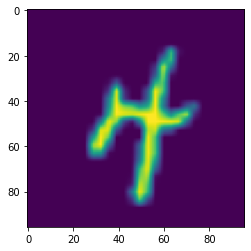

In [7]:
from skimage.transform import rescale, resize, downscale_local_mean

mnist_resized = resize(mnist_sq[342], (n_xy, n_xy),
                       anti_aliasing=True) / 3.

plt.imshow(mnist_resized)

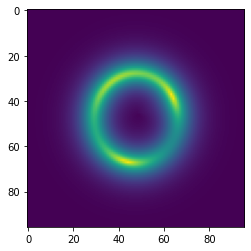

In [8]:
# Lensed image

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image()

plt.imshow(image)

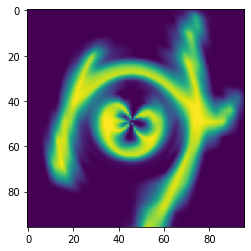

In [9]:
# Change the lens position

src_param_dict = {"profile": "CartesianGrid", "src_ary": mnist_resized} 
# hst_param_dict = {"profile": "SIE", "theta_x_0": 0.3, "theta_y_0": 0.4, "theta_E": 1., "q": 0.7}

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image()

plt.imshow(image.T)

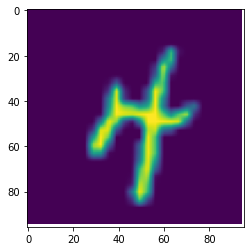

In [10]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image_nolens = lsi.lensed_image()

plt.imshow(image_nolens.T)

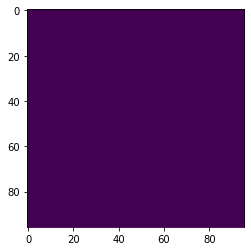

In [11]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [], global_dict, observation_dict)
image_nosrc = lsi.lensed_image()

plt.imshow(image_nosrc)

In [12]:
np.max(image_nolens - image_nosrc)

DeviceArray(nan, dtype=float64)

## Custom source

In [13]:
import sys
sys.path.append("../")

from simulator.profiles import LightProfileSersic


In [14]:
# theta_x_lims = theta_y_lims = [-1.5, 1.5]
# n_x = n_y = 64

# theta_x, theta_y = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_x), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_y))

# inputs = LightProfileSersic(x_0=0.3, y_0=0., S_tot=5., r_e=1., n_srsc=4,).flux(theta_x, theta_y)

In [15]:
from jax import vmap
from einops import rearrange, repeat

In [16]:
# Lensed image

def render_lens(inputs):
    lens_list = [hst_param_dict]
    src_param_dict = {"profile": "CartesianGrid", "src_ary": inputs}    

    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    
    return image


# image = render_lens(inputs)

# plt.imshow(image)

In [17]:
render_lens_vmapped = vmap(render_lens)

# render_lens_vmapped(repeat(inputs, "h w -> b h w", b=128)).shape

## NeRF

In [18]:
def positional_encoding(inputs, positional_encoding_dims=2):
    batch_size, _ = inputs.shape
    # Applying vmap transform to vectorize the multiplication operation
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [19]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [20]:
num_dense_layers = 6
dense_layer_width = 128
add_positional_encoding = True

In [21]:
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        for i in range(num_dense_layers):
            # Apply positional encoding to the input points
            
            if add_positional_encoding:
                x = positional_encoding(input_points)
            else:
                x = input_points
                        
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.relu(x)
            # Skip connection
            x = jnp.concatenate([x, input_points], axis=-1) if i == 3 else x

        x = nn.Dense(n_xy * n_xy, dtype=self.dtype)(x)
        return x


In [22]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [23]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(0))

# Initialize the Model
model, params = initialize_model(key, (1, 2 * n_xy * n_xy))

In [24]:
input_to_network = jnp.ones((1, 2 * n_xy * n_xy))

In [25]:
model.apply({"params": params}, input_to_network).shape

(1, 9216)

In [26]:
model_fn = lambda x: model.apply({"params": params}, x)
model_output = model_fn(input_to_network)
model_output.shape

(1, 9216)

In [27]:
def train_step(state, batch):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> 1 (c h w)")
                       
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output = model_fn(inputs)
        model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)

        lenses = render_lens_vmapped(model_output)
        
        # Compute mean-squared error
        loss_mse = jnp.mean((lenses - targets) ** 2)
        return loss_mse
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state 

In [28]:
learning_rate = 6e-4
weight_decay = 1e-6

In [29]:
theta_x_lims = theta_y_lims = [-1., 1.]
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)

In [30]:
train_epochs = 2000

In [31]:
coords.shape, image_input.shape

((2, 96, 96), (1, 96, 96))

In [32]:
from celluloid import Camera

# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(43))

# Initialize the Model
model, params = initialize_model(key, (1, 2 * n_xy * n_xy))

# Define the Optimizer
optimizer = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)

# Create the Training State
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)


# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn):
    
    # camera = Camera(fig)
    
    train_loss_history, train_psnr_history = [], []
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        train_loss, train_psnr, state = train_step_fn(state, train_batch)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % 50 == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
            model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
            
            lenses = render_lens_vmapped(model_output)
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
            
            ax1.imshow(model_output[0])
            ax1.set_title(f"Predicted source at epoch {epoch}")
            ax1.axis("off")
            ax2.imshow(image_nolens.T)
            ax2.set_title(f"True source")
            ax2.axis("off")
            ax3.imshow(lenses[0].T)
            ax3.set_title(f"Predicted lensed image at epoch {epoch}")
            ax3.axis("off")
            ax4.imshow(image_input[0].T)
            ax4.set_title(f"True lensed image")
            ax4.axis("off")
            plt.show()
            # camera.snap()
    
    history = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
    }
    
    return state, history, camera

  0%|          | 0/2000 [00:00<?, ?it/s]

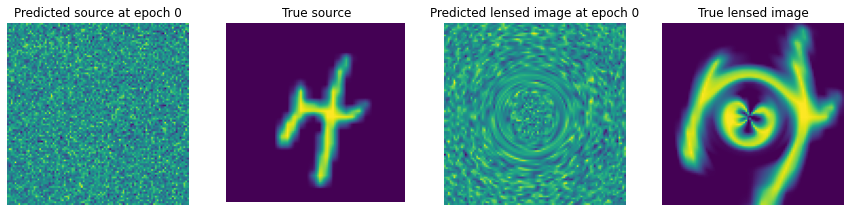

  2%|▎         | 50/2000 [00:29<16:08,  2.01it/s] 

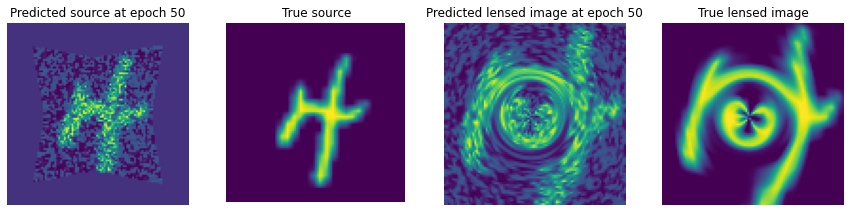

  5%|▌         | 100/2000 [00:55<16:06,  1.97it/s]

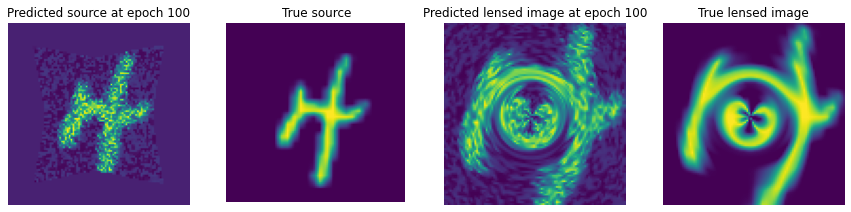

  8%|▊         | 150/2000 [01:21<15:38,  1.97it/s]

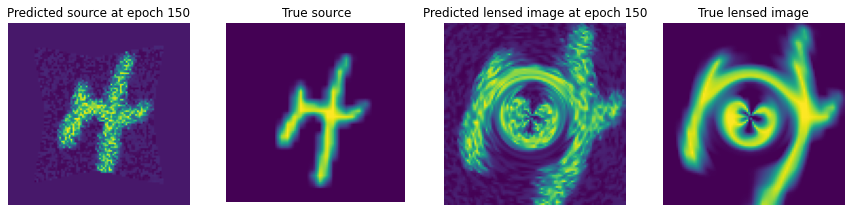

 10%|█         | 200/2000 [01:47<15:26,  1.94it/s]

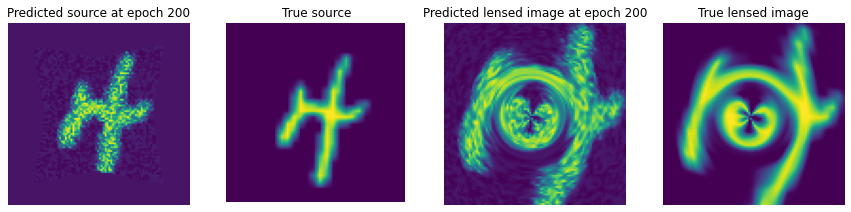

 12%|█▎        | 250/2000 [02:14<15:07,  1.93it/s]

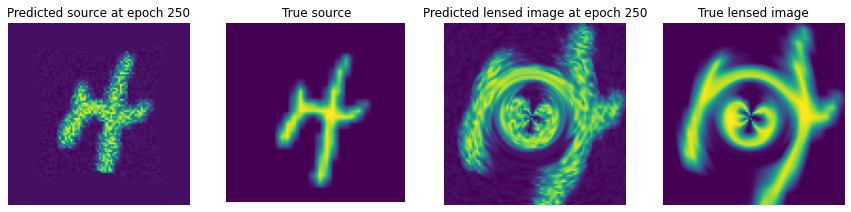

 15%|█▌        | 300/2000 [02:41<14:50,  1.91it/s]

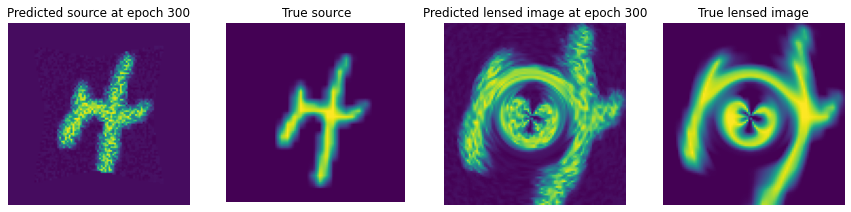

 18%|█▊        | 350/2000 [03:08<14:30,  1.89it/s]

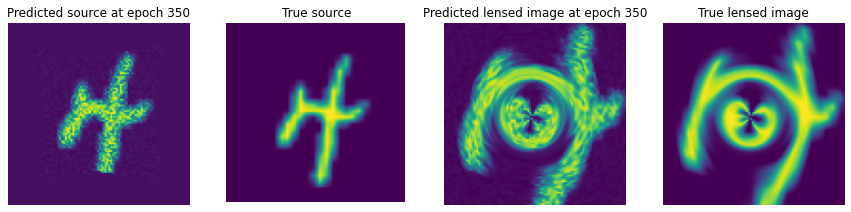

 20%|██        | 400/2000 [03:35<14:09,  1.88it/s]

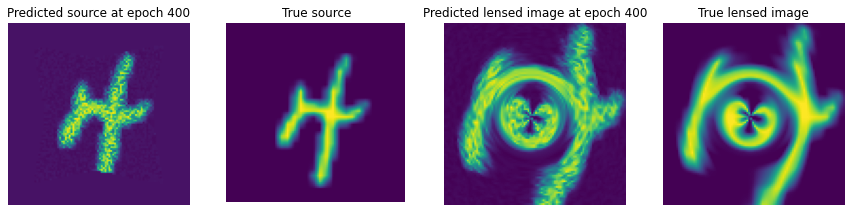

 22%|██▎       | 450/2000 [04:02<13:47,  1.87it/s]

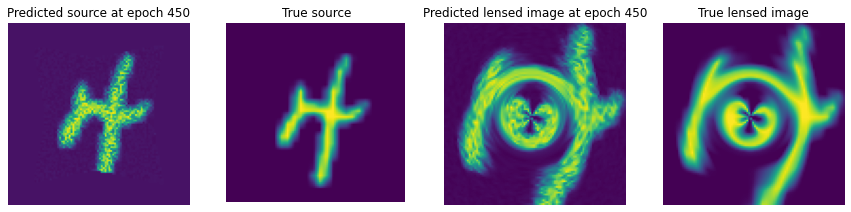

 25%|██▌       | 500/2000 [04:30<13:31,  1.85it/s]

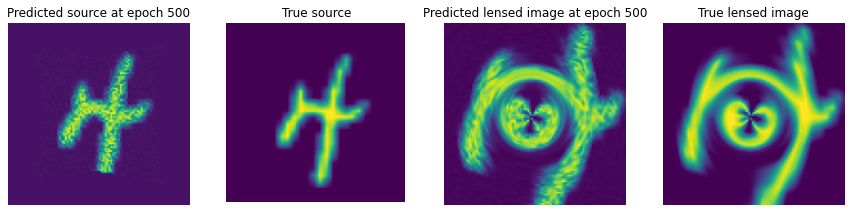

 28%|██▊       | 550/2000 [04:58<13:08,  1.84it/s]

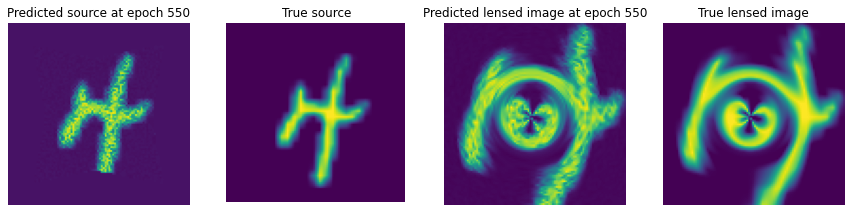

 30%|███       | 600/2000 [05:26<12:53,  1.81it/s]

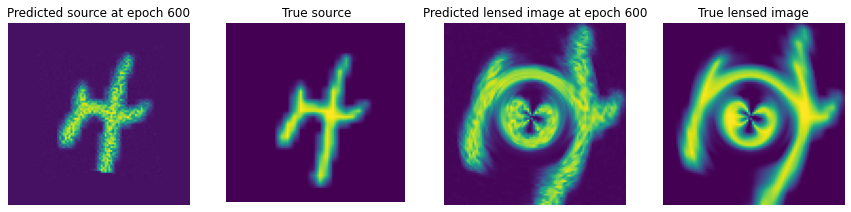

 32%|███▎      | 650/2000 [05:54<13:16,  1.69it/s]

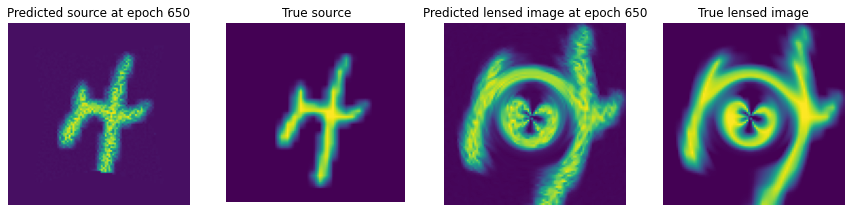

 35%|███▌      | 700/2000 [06:22<11:57,  1.81it/s]

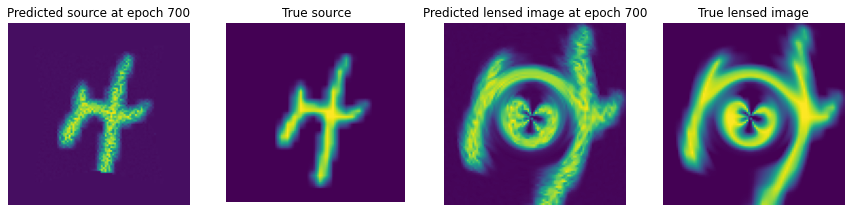

 38%|███▊      | 750/2000 [06:51<11:50,  1.76it/s]

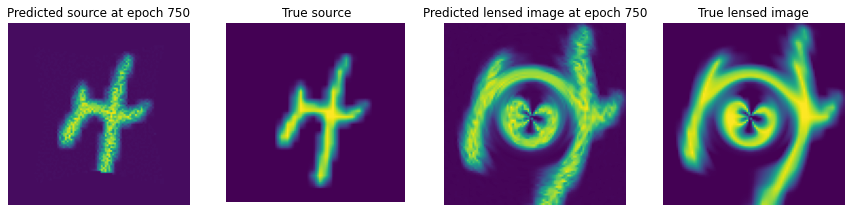

 40%|████      | 800/2000 [07:20<11:14,  1.78it/s]

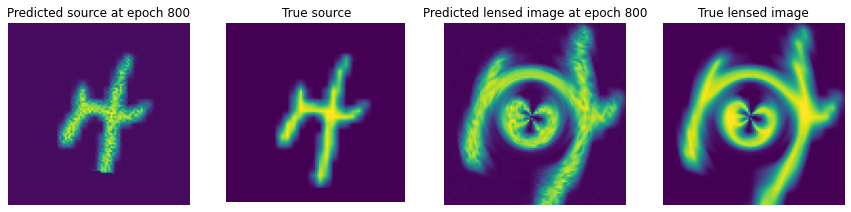

 42%|████▎     | 850/2000 [07:49<10:59,  1.74it/s]

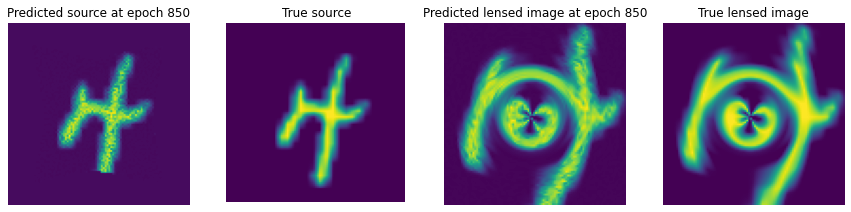

 45%|████▌     | 900/2000 [08:19<10:27,  1.75it/s]

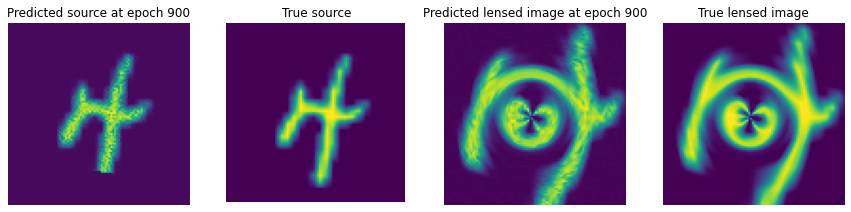

 48%|████▊     | 950/2000 [08:48<10:04,  1.74it/s]

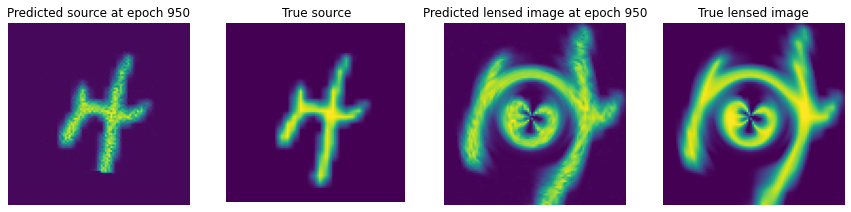

 50%|█████     | 1000/2000 [09:17<09:34,  1.74it/s]

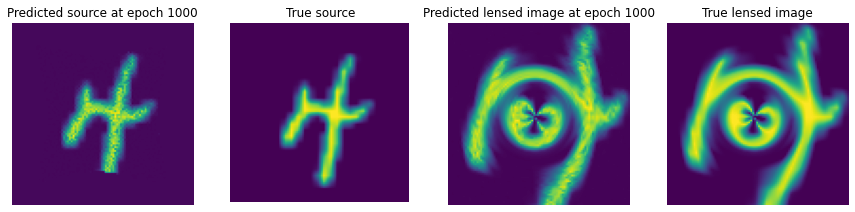

 52%|█████▎    | 1050/2000 [09:47<09:16,  1.71it/s]

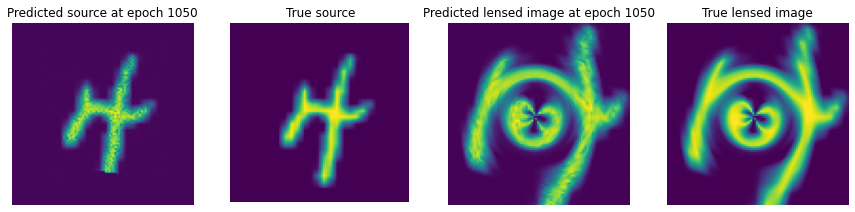

 55%|█████▌    | 1100/2000 [10:17<09:08,  1.64it/s]

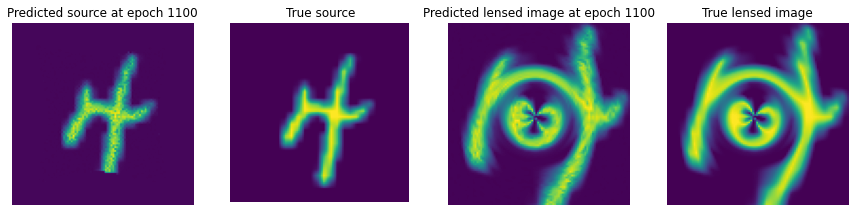

 57%|█████▊    | 1150/2000 [10:47<08:18,  1.71it/s]

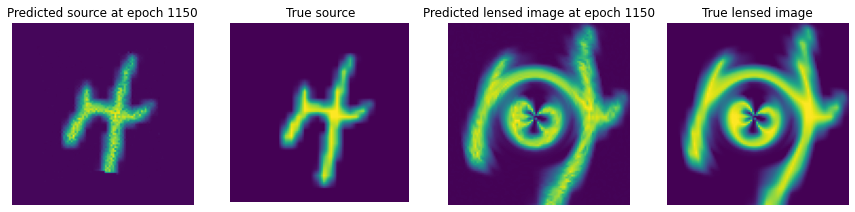

 60%|██████    | 1200/2000 [11:17<07:56,  1.68it/s]

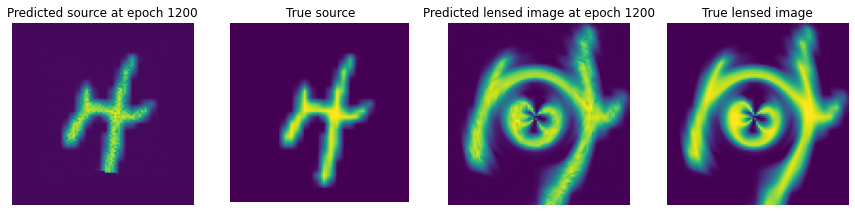

 62%|██████▎   | 1250/2000 [11:49<07:29,  1.67it/s]

In [ ]:
state, history, camera = train_and_evaluate(state, train_step)

In [349]:
animation = camera.animate()
animation.save('render.gif', fps=10)

In [ ]:
history["train_loss"]

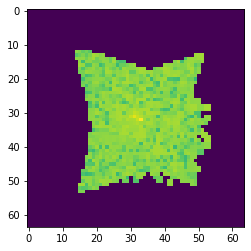

In [34]:
model_fn = lambda x: state.apply_fn({"params": state.params}, x)
model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
plt.imshow(model_output[0])